In [1]:
!pip install missingno

In [2]:
!pip install catboost

In [3]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import train & test data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv') 
# example of what a submission should look like

In [5]:
# View the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
len(train)

891

In [7]:
# View the test data
test.head()
len(test)

418

In [8]:
# Example submisison dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## What missing values are there?

<AxesSubplot:>

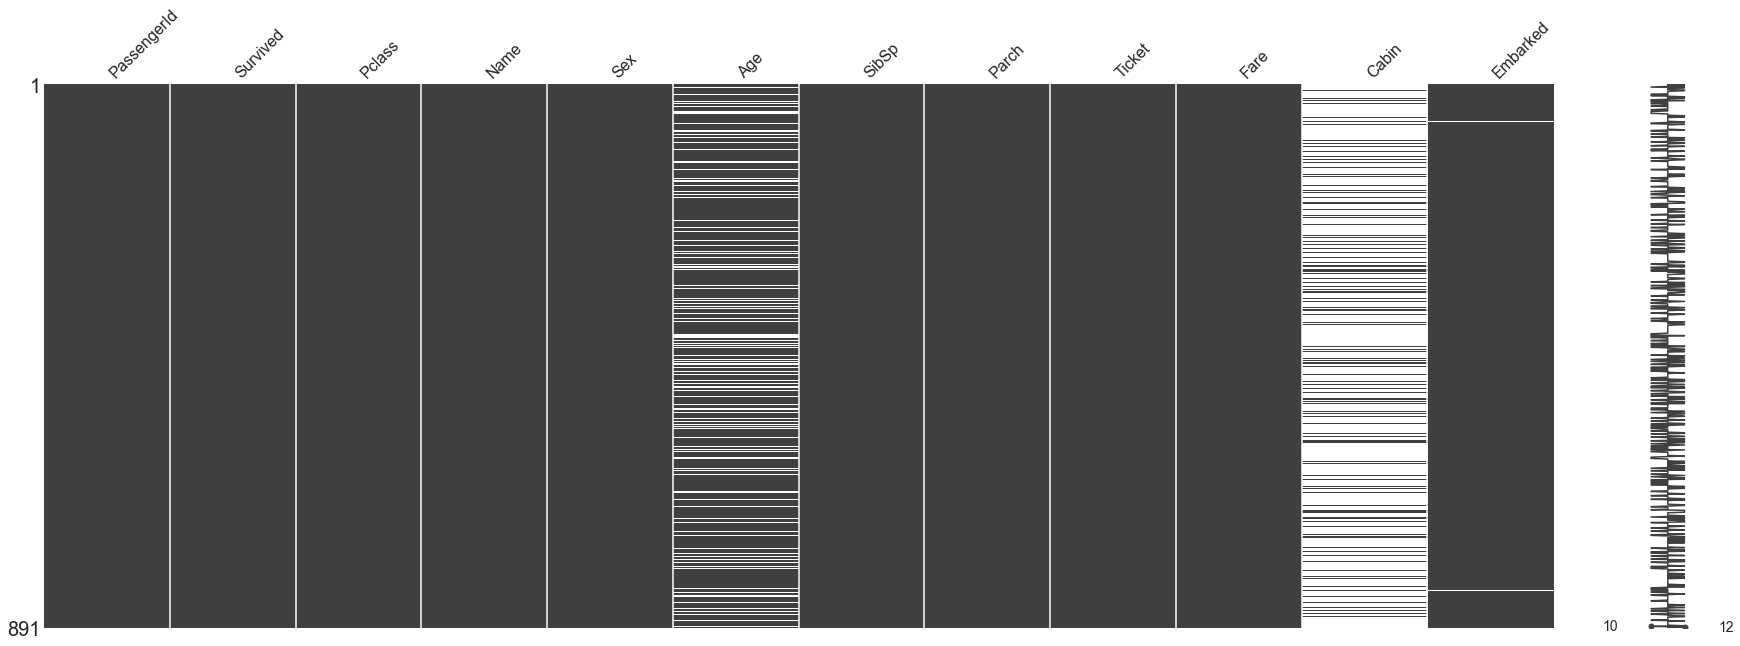

In [10]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [11]:
len(train)

891

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
# Creating a function to identify how many missing values in each column
def find_missing_values(df,columns):
    missing_vals = {}
    print("Displaying a no of missing values or NAN valus by each row")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
    return missing_vals
    
missing_values = find_missing_values(train,columns= train.columns)
missing_values  

Displaying a no of missing values or NAN valus by each row


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [14]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [15]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

## What datatypes are in the dataframe?

As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind. 

In [16]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models.
Some may need more preprocessing than others to get ready.

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Target Feature: Survived

Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived
    
This is the variable we want our machine learning model to predict based off all the others.

In [18]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

0    549
1    342
Name: Survived, dtype: int64


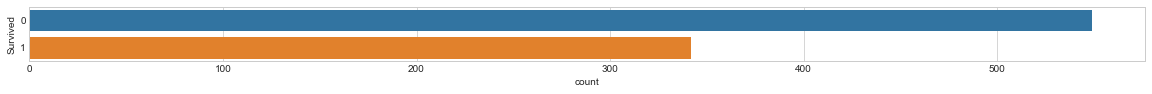

In [19]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [20]:
train['Survived'].value_counts().keys()

Int64Index([0, 1], dtype='int64')

In [21]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [22]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [23]:
df_bin.shape

(891, 1)

In [24]:
df_con.shape

(891, 1)

In [25]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

#### Let's plot the distribution
We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

<AxesSubplot:xlabel='Pclass', ylabel='Density'>

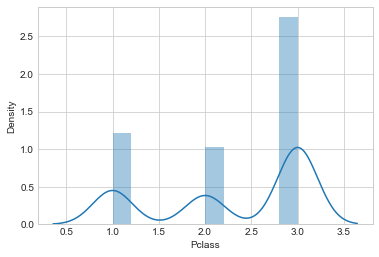

In [26]:
sns.distplot(train.Pclass)

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

How do we know this? Because a passenger in Class 3 doesn't necessarily equal a passenger in Class 2 + a passenger in Class 1.

In [27]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [28]:
train['Pclass'].value_counts().keys()

Int64Index([3, 1, 2], dtype='int64')

In [29]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [30]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [31]:
df_bin['Pclass'].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [32]:
df_con['Pclass'].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

### Feature: Name
    
Description: The name of the passenger.

In [33]:
# How many different names are there?
train.Name.value_counts()

Asim, Mr. Adola                                                      1
Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)            1
Carter, Mrs. Ernest Courtenay (Lilian Hughes)                        1
Moran, Miss. Bertha                                                  1
Colley, Mr. Edward Pomeroy                                           1
                                                                    ..
Flynn, Mr. James                                                     1
McEvoy, Mr. Michael                                                  1
Beane, Mr. Edward                                                    1
Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")    1
Backstrom, Mrs. Karl Alfred (Maria Mathilda Gustafsson)              1
Name: Name, Length: 891, dtype: int64

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

Can you think of ways you could reduce the number of different names? Or create new features out of the names?

**Note:** Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

### Feature: Sex

Description: The sex of the passenger (male or female).

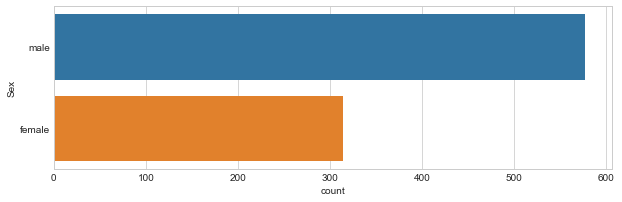

In [34]:
# Let's view the distribution of Sex
plt.figure(figsize=(10, 3))
sns.countplot(y="Sex", data=train);

In [35]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [36]:
train['Sex'].value_counts().keys()

Index(['male', 'female'], dtype='object')

In [37]:
# Are there any missing values in the Sex column?
train.Sex.isnull().sum()

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [38]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [39]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

In [40]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


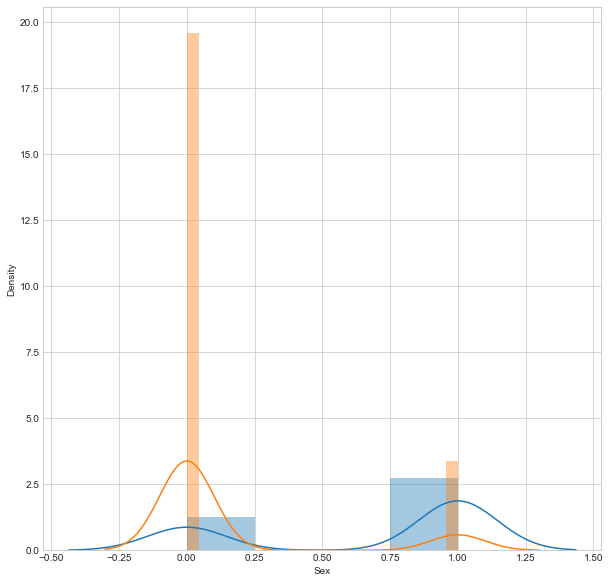

In [41]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

Not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [42]:
train['Age'].value_counts()

24.00    30
22.00    27
18.00    26
28.00    25
19.00    25
         ..
55.50     1
74.00     1
0.92      1
70.50     1
12.00     1
Name: Age, Length: 88, dtype: int64

In [43]:
train['Age'].value_counts().keys()

Float64Index([24.0, 22.0, 18.0, 28.0, 19.0, 30.0, 21.0, 25.0, 36.0, 29.0, 35.0,
              32.0, 27.0, 26.0, 16.0, 31.0, 33.0, 34.0, 23.0, 20.0, 39.0, 42.0,
              40.0, 17.0, 45.0, 38.0,  4.0,  2.0, 50.0, 47.0, 48.0, 44.0,  9.0,
              54.0, 51.0,  1.0, 14.0,  3.0, 41.0, 37.0, 52.0, 49.0, 15.0, 43.0,
              58.0,  8.0, 60.0, 11.0, 56.0,  5.0, 62.0, 65.0,  7.0, 61.0, 46.0,
               6.0, 40.5, 10.0, 0.75, 30.5, 64.0, 32.5, 0.83, 59.0, 70.0, 63.0,
              28.5, 71.0, 13.0, 57.0, 55.0, 45.5, 24.5, 66.0, 20.5, 0.67, 80.0,
              14.5, 34.5, 23.5, 53.0, 36.5, 0.42, 55.5, 74.0, 0.92, 70.5,
              12.0],
             dtype='float64')

In [44]:
train['Age'].shape

(891,)

In [45]:
# How many missing values does age have?
train.Age.isnull().sum()

177

In [46]:
#train = train['Age'].dropna()

In [47]:
#train.groupby(['Sex']).Age.mean()

In [48]:
#train.groupby(['Sex']).Age.agg(['mean','min','max'])

In [49]:
#train.Age.rolling(window=5,min_periods=1).agg(['sum','min'])

# Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.


In [50]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
df_con['Age'] = train['Age'] # non-bucketed

**Challenge:** How would you fill the missing variables in the `Age` column?

#### Function to create count and distribution visualisations

In [51]:
 def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
        if use_bin_df:
            fig = plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            sns.countplot(y=target_column, data=bin_df);
            plt.subplot(1, 2, 2)
            sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
            sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
        else:
            fig = plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            sns.countplot(y=target_column, data=data);
            plt.subplot(1, 2, 2)
            sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
            sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [52]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [53]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [54]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

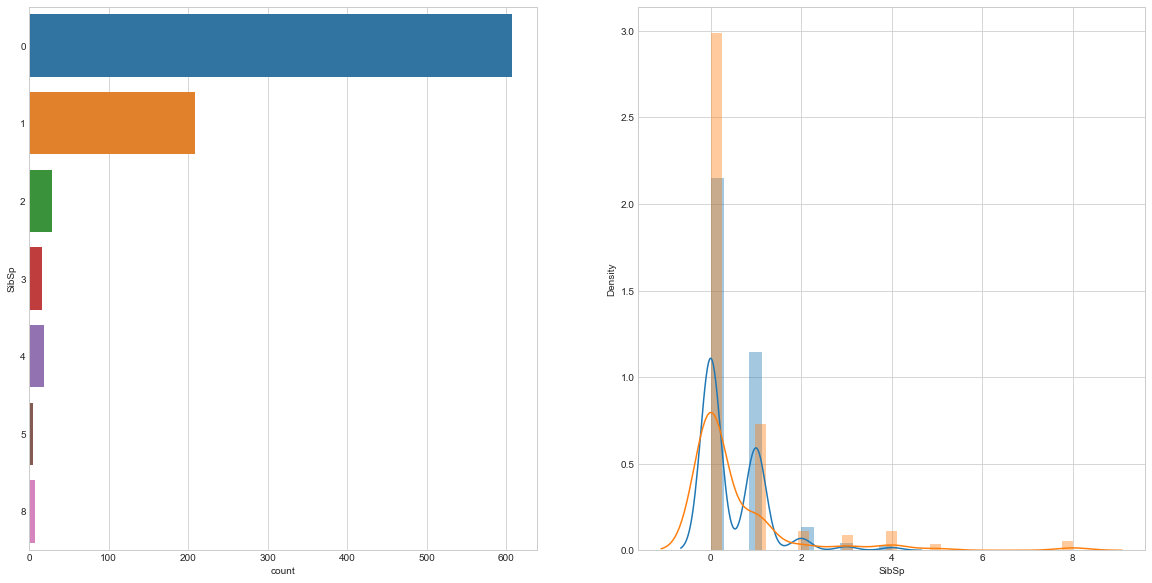

In [55]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

What does the graph on the right tell us?

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [56]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [57]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [58]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

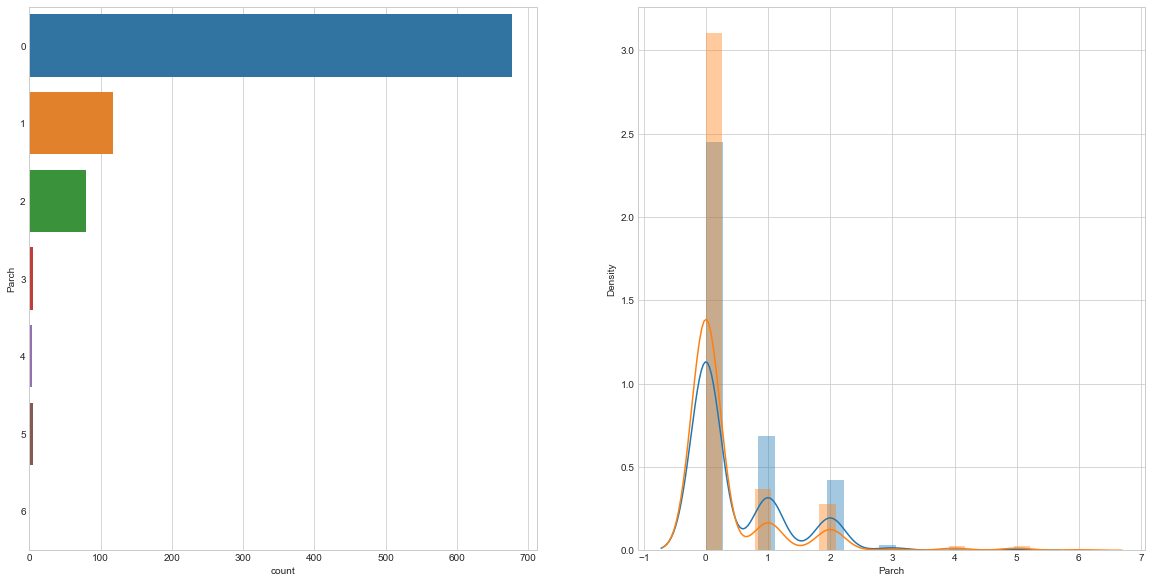

In [59]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

What does the graph on the right tell us about `Parch`?

In [60]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [62]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

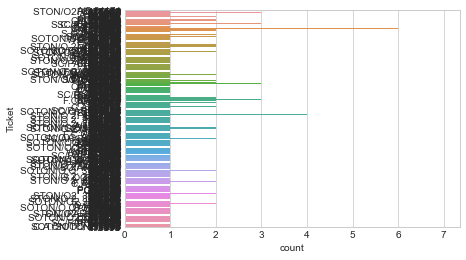

In [63]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

That doesn't look too good, what about another way of looking at it?

In [64]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

1601         7
347082       7
CA. 2343     7
347088       6
CA 2144      6
            ..
347063       1
C.A. 5547    1
345572       1
350407       1
365226       1
Name: Ticket, Length: 681, dtype: int64

In [65]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use `Ticket` in our subset dataframes.

There may be some way to reduce this down. 

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

*Hint:* It may be similar to what you could do with Name.

### Feature: Fare

Description: How much the ticket cost.

In [66]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

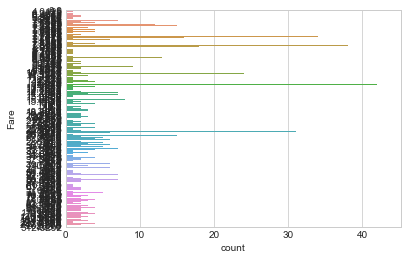

In [67]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [68]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [69]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [70]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [71]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

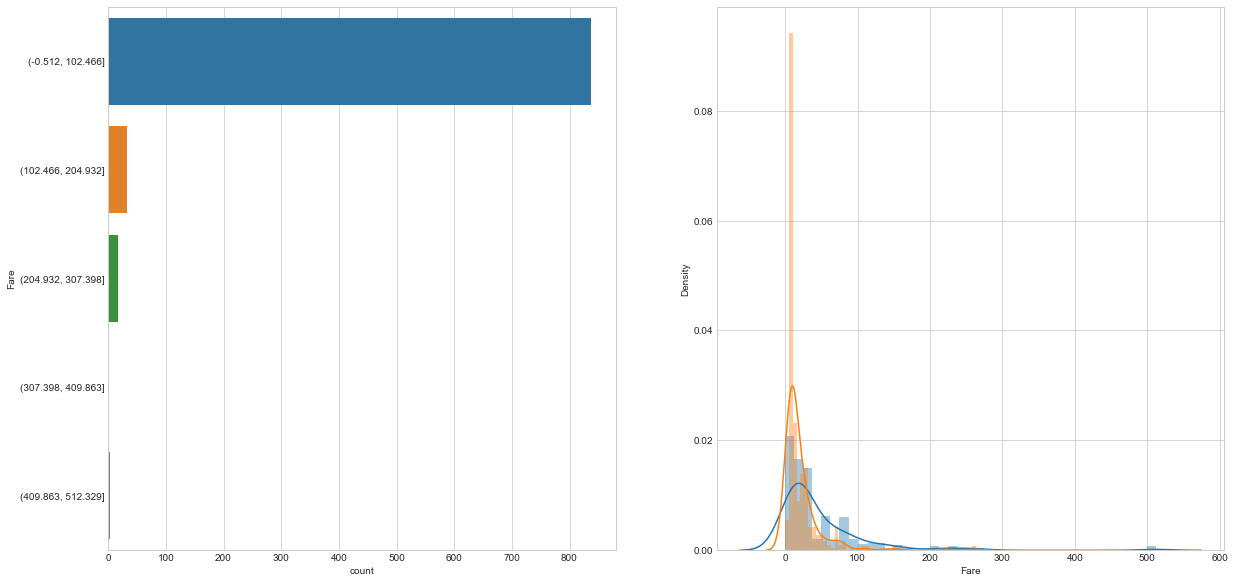

In [72]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

**Challenge:** How would you change the Fare bins?

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [73]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [74]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
# What do the Cabin values look like?
train.Cabin.value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
C22 C26        3
E101           3
              ..
D9             1
E50            1
E17            1
C85            1
D15            1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [76]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [77]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

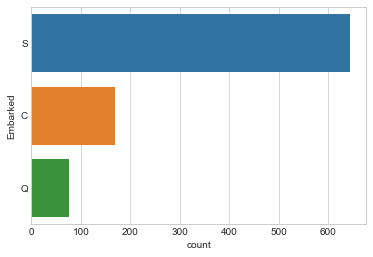

In [78]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

#### How can we deal with the 2 missing values of Embarked?

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

What are the pros and cons of each?

For now, we will remove those rows.

In [79]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [80]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [81]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]",S
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",C
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]",S
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",S
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]",S


In [82]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]",...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [83]:
df_con.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


**Update:** The original version of this notebook used the `LabelEncoder()` function for encoding `df_con_enc`. However, as Tomáš pointed out, OneHotEncoder is better to use.
    
Check this article for more details: https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

In [84]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [85]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [86]:
# Let's look at df_con_enc
df_con_enc = df_con.apply(LabelEncoder().fit_transform)
df_con_enc.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,1,28,1,0,18,2
1,1,0,0,51,1,0,207,0
2,1,2,0,34,0,0,41,2
3,1,0,0,47,1,0,189,2
4,0,2,1,47,0,0,43,2
5,0,2,1,88,0,0,51,1
6,0,0,1,69,0,0,186,2
7,0,2,1,6,3,1,124,2
8,1,2,0,35,0,2,74,2
9,1,1,0,18,1,0,154,0


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [87]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [88]:
selected_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,1,28,1,0,18,2
1,1,0,0,51,1,0,207,0
2,1,2,0,34,0,0,41,2
3,1,0,0,47,1,0,189,2
4,0,2,1,47,0,0,43,2


In [89]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [90]:
# Shape of the data (without labels)
X_train.shape

(889, 7)

In [91]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,51,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,47,1,0,189,2
4,2,1,47,0,0,43,2


In [92]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [93]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [94]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.19
Running Time: 0:00:03.858835


### K-Nearest Neighbours

In [95]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 78.63
Accuracy CV 10-Fold: 69.63
Running Time: 0:00:00.177298


### Gaussian Naive Bayes

In [96]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 77.28
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.062831


### Linear Support Vector Machines (SVC)

In [97]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 75.48
Accuracy CV 10-Fold: 68.62
Running Time: 0:00:00.317706


### Stochastic Gradient Descent

In [98]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 66.7
Accuracy CV 10-Fold: 68.28
Running Time: 0:00:00.135221


### Decision Tree Classifier

In [99]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 98.2
Accuracy CV 10-Fold: 77.62
Running Time: 0:00:00.093749


### Gradient Boost Trees

In [100]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 89.54
Accuracy CV 10-Fold: 83.01
Running Time: 0:00:00.733464


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [101]:
# View the data for the CatBoost model
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,51,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,47,1,0,189,2
4,2,1,47,0,0,43,2


In [102]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [103]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [104]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [105]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [107]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6873775	total: 18.2ms	remaining: 18.2s
1:	learn: 0.6819329	total: 38ms	remaining: 19s
2:	learn: 0.6768154	total: 51.6ms	remaining: 17.1s
3:	learn: 0.6714559	total: 76.9ms	remaining: 19.1s
4:	learn: 0.6663391	total: 95ms	remaining: 18.9s
5:	learn: 0.6608615	total: 123ms	remaining: 20.4s
6:	learn: 0.6557134	total: 146ms	remaining: 20.7s
7:	learn: 0.6505673	total: 167ms	remaining: 20.7s
8:	learn: 0.6460145	total: 184ms	remaining: 20.3s
9:	learn: 0.6414120	total: 205ms	remaining: 20.3s
10:	learn: 0.6370123	total: 229ms	remaining: 20.6s
11:	learn: 0.6323069	total: 253ms	remaining: 20.8s
12:	learn: 0.6273831	total: 272ms	remaining: 20.6s
13:	learn: 0.6246657	total: 281ms	remaining: 19.8s
14:	learn: 0.6203743	total: 299ms	remaining: 19.6s
15:	learn: 0.6163063	total: 318ms	remaining: 19.5s
16:	learn: 0.6125971	total: 337ms	remaining: 19.5s
17:	learn: 0.6085960	total: 358ms	remaining: 19.5s
18:	learn: 0.6048136	total: 378ms	remaining: 19.5s
19:	learn: 0

169:	learn: 0.4113647	total: 3.25s	remaining: 15.9s
170:	learn: 0.4109022	total: 3.27s	remaining: 15.9s
171:	learn: 0.4105490	total: 3.29s	remaining: 15.9s
172:	learn: 0.4101866	total: 3.31s	remaining: 15.8s
173:	learn: 0.4097486	total: 3.34s	remaining: 15.8s
174:	learn: 0.4092196	total: 3.35s	remaining: 15.8s
175:	learn: 0.4088209	total: 3.37s	remaining: 15.8s
176:	learn: 0.4082646	total: 3.39s	remaining: 15.8s
177:	learn: 0.4078618	total: 3.41s	remaining: 15.8s
178:	learn: 0.4078388	total: 3.42s	remaining: 15.7s
179:	learn: 0.4075339	total: 3.44s	remaining: 15.7s
180:	learn: 0.4069485	total: 3.46s	remaining: 15.6s
181:	learn: 0.4067599	total: 3.48s	remaining: 15.6s
182:	learn: 0.4063006	total: 3.5s	remaining: 15.6s
183:	learn: 0.4055123	total: 3.51s	remaining: 15.6s
184:	learn: 0.4052764	total: 3.53s	remaining: 15.6s
185:	learn: 0.4047556	total: 3.55s	remaining: 15.5s
186:	learn: 0.4046725	total: 3.56s	remaining: 15.5s
187:	learn: 0.4042032	total: 3.58s	remaining: 15.5s
188:	learn: 0

333:	learn: 0.3642573	total: 6.66s	remaining: 13.3s
334:	learn: 0.3639627	total: 6.68s	remaining: 13.3s
335:	learn: 0.3638779	total: 6.7s	remaining: 13.2s
336:	learn: 0.3634803	total: 6.72s	remaining: 13.2s
337:	learn: 0.3631156	total: 6.74s	remaining: 13.2s
338:	learn: 0.3628860	total: 6.76s	remaining: 13.2s
339:	learn: 0.3626213	total: 6.79s	remaining: 13.2s
340:	learn: 0.3626178	total: 6.8s	remaining: 13.1s
341:	learn: 0.3624828	total: 6.82s	remaining: 13.1s
342:	learn: 0.3624648	total: 6.83s	remaining: 13.1s
343:	learn: 0.3624644	total: 6.83s	remaining: 13s
344:	learn: 0.3623175	total: 6.85s	remaining: 13s
345:	learn: 0.3622487	total: 6.87s	remaining: 13s
346:	learn: 0.3621298	total: 6.89s	remaining: 13s
347:	learn: 0.3618087	total: 6.91s	remaining: 12.9s
348:	learn: 0.3616852	total: 6.92s	remaining: 12.9s
349:	learn: 0.3613124	total: 6.94s	remaining: 12.9s
350:	learn: 0.3611286	total: 6.96s	remaining: 12.9s
351:	learn: 0.3609974	total: 6.98s	remaining: 12.8s
352:	learn: 0.3609901	

497:	learn: 0.3390261	total: 9.72s	remaining: 9.8s
498:	learn: 0.3388096	total: 9.74s	remaining: 9.78s
499:	learn: 0.3386472	total: 9.77s	remaining: 9.77s
500:	learn: 0.3383821	total: 9.79s	remaining: 9.75s
501:	learn: 0.3383280	total: 9.81s	remaining: 9.74s
502:	learn: 0.3380282	total: 9.85s	remaining: 9.73s
503:	learn: 0.3379252	total: 9.87s	remaining: 9.71s
504:	learn: 0.3378266	total: 9.89s	remaining: 9.69s
505:	learn: 0.3376945	total: 9.9s	remaining: 9.67s
506:	learn: 0.3376478	total: 9.93s	remaining: 9.65s
507:	learn: 0.3374514	total: 9.95s	remaining: 9.63s
508:	learn: 0.3372623	total: 9.96s	remaining: 9.61s
509:	learn: 0.3370987	total: 9.98s	remaining: 9.59s
510:	learn: 0.3370613	total: 10s	remaining: 9.57s
511:	learn: 0.3368726	total: 10s	remaining: 9.55s
512:	learn: 0.3368037	total: 10s	remaining: 9.53s
513:	learn: 0.3366377	total: 10.1s	remaining: 9.51s
514:	learn: 0.3363701	total: 10.1s	remaining: 9.49s
515:	learn: 0.3361686	total: 10.1s	remaining: 9.46s
516:	learn: 0.335938

661:	learn: 0.3146061	total: 12.9s	remaining: 6.57s
662:	learn: 0.3145049	total: 12.9s	remaining: 6.55s
663:	learn: 0.3144201	total: 12.9s	remaining: 6.53s
664:	learn: 0.3142628	total: 12.9s	remaining: 6.52s
665:	learn: 0.3140649	total: 13s	remaining: 6.5s
666:	learn: 0.3138415	total: 13s	remaining: 6.48s
667:	learn: 0.3137161	total: 13s	remaining: 6.46s
668:	learn: 0.3136473	total: 13s	remaining: 6.44s
669:	learn: 0.3134872	total: 13s	remaining: 6.42s
670:	learn: 0.3132807	total: 13.1s	remaining: 6.41s
671:	learn: 0.3131345	total: 13.1s	remaining: 6.39s
672:	learn: 0.3128586	total: 13.1s	remaining: 6.37s
673:	learn: 0.3128491	total: 13.1s	remaining: 6.34s
674:	learn: 0.3126430	total: 13.1s	remaining: 6.32s
675:	learn: 0.3124673	total: 13.2s	remaining: 6.3s
676:	learn: 0.3123104	total: 13.2s	remaining: 6.28s
677:	learn: 0.3122720	total: 13.2s	remaining: 6.26s
678:	learn: 0.3122193	total: 13.2s	remaining: 6.25s
679:	learn: 0.3119440	total: 13.2s	remaining: 6.23s
680:	learn: 0.3119308	to

829:	learn: 0.2937219	total: 16.2s	remaining: 3.31s
830:	learn: 0.2935648	total: 16.2s	remaining: 3.29s
831:	learn: 0.2933919	total: 16.2s	remaining: 3.27s
832:	learn: 0.2932507	total: 16.2s	remaining: 3.26s
833:	learn: 0.2931575	total: 16.3s	remaining: 3.24s
834:	learn: 0.2930148	total: 16.3s	remaining: 3.22s
835:	learn: 0.2929561	total: 16.3s	remaining: 3.2s
836:	learn: 0.2928512	total: 16.3s	remaining: 3.18s
837:	learn: 0.2928097	total: 16.3s	remaining: 3.16s
838:	learn: 0.2927437	total: 16.4s	remaining: 3.14s
839:	learn: 0.2926677	total: 16.4s	remaining: 3.12s
840:	learn: 0.2925868	total: 16.4s	remaining: 3.1s
841:	learn: 0.2924585	total: 16.4s	remaining: 3.08s
842:	learn: 0.2924364	total: 16.4s	remaining: 3.06s
843:	learn: 0.2923926	total: 16.5s	remaining: 3.04s
844:	learn: 0.2921014	total: 16.5s	remaining: 3.02s
845:	learn: 0.2919984	total: 16.5s	remaining: 3s
846:	learn: 0.2919552	total: 16.5s	remaining: 2.98s
847:	learn: 0.2918567	total: 16.5s	remaining: 2.96s
848:	learn: 0.291

990:	learn: 0.2777976	total: 19.4s	remaining: 176ms
991:	learn: 0.2776618	total: 19.4s	remaining: 157ms
992:	learn: 0.2776331	total: 19.4s	remaining: 137ms
993:	learn: 0.2775441	total: 19.4s	remaining: 117ms
994:	learn: 0.2774287	total: 19.5s	remaining: 97.8ms
995:	learn: 0.2773968	total: 19.5s	remaining: 78.2ms
996:	learn: 0.2772523	total: 19.5s	remaining: 58.7ms
997:	learn: 0.2771508	total: 19.5s	remaining: 39.1ms
998:	learn: 0.2771198	total: 19.5s	remaining: 19.6ms
999:	learn: 0.2770948	total: 19.6s	remaining: 0us


### Perform CatBoost cross-validation

In [108]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6777899	test: 0.6784206	best: 0.6784206 (0)
1:	learn: 0.6618660	test: 0.6624649	best: 0.6624649 (1)
2:	learn: 0.6461428	test: 0.6470117	best: 0.6470117 (2)
3:	learn: 0.6316887	test: 0.6329300	best: 0.6329300 (3)
4:	learn: 0.6192054	test: 0.6202433	best: 0.6202433 (4)
5:	learn: 0.6072418	test: 0.6090065	best: 0.6090065 (5)
6:	learn: 0.5958459	test: 0.5982172	best: 0.5982172 (6)
7:	learn: 0.5854390	test: 0.5879246	best: 0.5879246 (7)
8:	learn: 0.5756524	test: 0.5787947	best: 0.5787947 (8)
9:	learn: 0.5662456	test: 0.5701226	best: 0.5701226 (9)
10:	learn: 0.5570692	test: 0.5611165	best: 0.5611165 (10)
11:	learn: 0.5494391	test: 0.5538867	best: 0.5538867 (11)
12:	learn: 0.5427907	test: 0.5478450	best: 0.5478450 (12)
13:	learn: 0.5357096	test: 0.5413268	best: 0.5413268 (13)
14:	learn: 0.5290751	test: 0.5353098	best: 0.5353098 (14)
15:	learn: 0.5228197	test: 0.5293404	best: 0.5293404 (15)
16:	learn: 0.5172597	test: 0.5243761	best: 0.5243761 (16)
17:	learn: 0.5115340	test: 0.51904

141:	learn: 0.3463941	test: 0.4276980	best: 0.4276980 (141)
142:	learn: 0.3459138	test: 0.4273547	best: 0.4273547 (142)
143:	learn: 0.3456021	test: 0.4272181	best: 0.4272181 (143)
144:	learn: 0.3450572	test: 0.4271744	best: 0.4271744 (144)
145:	learn: 0.3443989	test: 0.4269172	best: 0.4269172 (145)
146:	learn: 0.3441014	test: 0.4267604	best: 0.4267604 (146)
147:	learn: 0.3436796	test: 0.4266612	best: 0.4266612 (147)
148:	learn: 0.3430600	test: 0.4264621	best: 0.4264621 (148)
149:	learn: 0.3425919	test: 0.4264261	best: 0.4264261 (149)
150:	learn: 0.3422274	test: 0.4263105	best: 0.4263105 (150)
151:	learn: 0.3417945	test: 0.4263001	best: 0.4263001 (151)
152:	learn: 0.3415115	test: 0.4262260	best: 0.4262260 (152)
153:	learn: 0.3408572	test: 0.4261510	best: 0.4261510 (153)
154:	learn: 0.3402408	test: 0.4260037	best: 0.4260037 (154)
155:	learn: 0.3396629	test: 0.4261251	best: 0.4260037 (154)
156:	learn: 0.3391489	test: 0.4260797	best: 0.4260037 (154)
157:	learn: 0.3387854	test: 0.4259328	be

282:	learn: 0.2863380	test: 0.4238346	best: 0.4226063 (246)
283:	learn: 0.2861022	test: 0.4238399	best: 0.4226063 (246)
284:	learn: 0.2857806	test: 0.4238246	best: 0.4226063 (246)
285:	learn: 0.2852758	test: 0.4235449	best: 0.4226063 (246)
286:	learn: 0.2849790	test: 0.4236731	best: 0.4226063 (246)
287:	learn: 0.2846213	test: 0.4237201	best: 0.4226063 (246)
288:	learn: 0.2843133	test: 0.4236171	best: 0.4226063 (246)
289:	learn: 0.2839348	test: 0.4235571	best: 0.4226063 (246)
290:	learn: 0.2836591	test: 0.4234593	best: 0.4226063 (246)
291:	learn: 0.2832598	test: 0.4234353	best: 0.4226063 (246)
292:	learn: 0.2828052	test: 0.4234407	best: 0.4226063 (246)
293:	learn: 0.2824122	test: 0.4232987	best: 0.4226063 (246)
294:	learn: 0.2819736	test: 0.4232977	best: 0.4226063 (246)
295:	learn: 0.2814926	test: 0.4231116	best: 0.4226063 (246)
296:	learn: 0.2811851	test: 0.4231065	best: 0.4226063 (246)
297:	learn: 0.2808421	test: 0.4230216	best: 0.4226063 (246)
298:	learn: 0.2804970	test: 0.4230318	be

442:	learn: 0.2373494	test: 0.4246396	best: 0.4226063 (246)
443:	learn: 0.2371197	test: 0.4246987	best: 0.4226063 (246)
444:	learn: 0.2368732	test: 0.4248625	best: 0.4226063 (246)
445:	learn: 0.2364673	test: 0.4248005	best: 0.4226063 (246)
446:	learn: 0.2362116	test: 0.4249849	best: 0.4226063 (246)
447:	learn: 0.2359521	test: 0.4247975	best: 0.4226063 (246)
448:	learn: 0.2356744	test: 0.4248215	best: 0.4226063 (246)
449:	learn: 0.2354229	test: 0.4247650	best: 0.4226063 (246)
450:	learn: 0.2351873	test: 0.4247019	best: 0.4226063 (246)
451:	learn: 0.2347997	test: 0.4245662	best: 0.4226063 (246)
452:	learn: 0.2344567	test: 0.4246321	best: 0.4226063 (246)
453:	learn: 0.2341316	test: 0.4247439	best: 0.4226063 (246)
454:	learn: 0.2338254	test: 0.4247711	best: 0.4226063 (246)
455:	learn: 0.2334897	test: 0.4248980	best: 0.4226063 (246)
456:	learn: 0.2332519	test: 0.4250783	best: 0.4226063 (246)
457:	learn: 0.2330220	test: 0.4248064	best: 0.4226063 (246)
458:	learn: 0.2329015	test: 0.4248424	be

583:	learn: 0.2036842	test: 0.4290294	best: 0.4226063 (246)
584:	learn: 0.2034020	test: 0.4289478	best: 0.4226063 (246)
585:	learn: 0.2032459	test: 0.4290067	best: 0.4226063 (246)
586:	learn: 0.2029464	test: 0.4291388	best: 0.4226063 (246)
587:	learn: 0.2027742	test: 0.4291560	best: 0.4226063 (246)
588:	learn: 0.2025862	test: 0.4290022	best: 0.4226063 (246)
589:	learn: 0.2023769	test: 0.4288560	best: 0.4226063 (246)
590:	learn: 0.2020925	test: 0.4288383	best: 0.4226063 (246)
591:	learn: 0.2018746	test: 0.4288678	best: 0.4226063 (246)
592:	learn: 0.2016353	test: 0.4289704	best: 0.4226063 (246)
593:	learn: 0.2014253	test: 0.4289186	best: 0.4226063 (246)
594:	learn: 0.2011555	test: 0.4290004	best: 0.4226063 (246)
595:	learn: 0.2008924	test: 0.4288126	best: 0.4226063 (246)
596:	learn: 0.2006529	test: 0.4287774	best: 0.4226063 (246)
597:	learn: 0.2004520	test: 0.4286760	best: 0.4226063 (246)
598:	learn: 0.2002799	test: 0.4287622	best: 0.4226063 (246)
599:	learn: 0.1999976	test: 0.4286860	be

718:	learn: 0.1767859	test: 0.4328109	best: 0.4226063 (246)
719:	learn: 0.1766675	test: 0.4328003	best: 0.4226063 (246)
720:	learn: 0.1765303	test: 0.4329658	best: 0.4226063 (246)
721:	learn: 0.1763607	test: 0.4330526	best: 0.4226063 (246)
722:	learn: 0.1762165	test: 0.4330859	best: 0.4226063 (246)
723:	learn: 0.1760766	test: 0.4332049	best: 0.4226063 (246)
724:	learn: 0.1759289	test: 0.4331846	best: 0.4226063 (246)
725:	learn: 0.1757716	test: 0.4333630	best: 0.4226063 (246)
726:	learn: 0.1755374	test: 0.4335194	best: 0.4226063 (246)
727:	learn: 0.1753477	test: 0.4338035	best: 0.4226063 (246)
728:	learn: 0.1751556	test: 0.4337822	best: 0.4226063 (246)
729:	learn: 0.1750086	test: 0.4337471	best: 0.4226063 (246)
730:	learn: 0.1748349	test: 0.4336919	best: 0.4226063 (246)
731:	learn: 0.1746357	test: 0.4338168	best: 0.4226063 (246)
732:	learn: 0.1744475	test: 0.4336955	best: 0.4226063 (246)
733:	learn: 0.1742954	test: 0.4336646	best: 0.4226063 (246)
734:	learn: 0.1741819	test: 0.4337296	be

860:	learn: 0.1544858	test: 0.4381643	best: 0.4226063 (246)
861:	learn: 0.1543147	test: 0.4381437	best: 0.4226063 (246)
862:	learn: 0.1541637	test: 0.4381211	best: 0.4226063 (246)
863:	learn: 0.1540111	test: 0.4382182	best: 0.4226063 (246)
864:	learn: 0.1539069	test: 0.4383012	best: 0.4226063 (246)
865:	learn: 0.1537823	test: 0.4384139	best: 0.4226063 (246)
866:	learn: 0.1536404	test: 0.4384234	best: 0.4226063 (246)
867:	learn: 0.1534620	test: 0.4383928	best: 0.4226063 (246)
868:	learn: 0.1533354	test: 0.4383495	best: 0.4226063 (246)
869:	learn: 0.1532295	test: 0.4382602	best: 0.4226063 (246)
870:	learn: 0.1531165	test: 0.4382420	best: 0.4226063 (246)
871:	learn: 0.1530304	test: 0.4383334	best: 0.4226063 (246)
872:	learn: 0.1528939	test: 0.4383025	best: 0.4226063 (246)
873:	learn: 0.1527520	test: 0.4383424	best: 0.4226063 (246)
874:	learn: 0.1526596	test: 0.4384030	best: 0.4226063 (246)
875:	learn: 0.1525120	test: 0.4385340	best: 0.4226063 (246)
876:	learn: 0.1523642	test: 0.4384669	be

In [109]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 89.43
Accuracy cross-validation 10-Fold: 81.66
Running Time: 0:04:27.581427


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

### Regular accuracy scores

In [110]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,98.20
6,Gradient Boosting Trees,89.54
7,CatBoost,89.43
1,Logistic Regression,79.98
0,KNN,78.63
2,Naive Bayes,77.28
4,Linear SVC,75.48
3,Stochastic Gradient Decent,66.70


In [111]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,83.01
7,CatBoost,81.66
1,Logistic Regression,79.19
5,Decision Tree,77.62
2,Naive Bayes,76.72
0,KNN,69.63
4,Linear SVC,68.62
3,Stochastic Gradient Decent,68.28


We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

## Feature Importance
Which features of the best model were most important for making predictions?

In [112]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

,imp,col
3,9.278278,SibSp
6,9.935787,Embarked
4,12.284400,Parch
5,13.635463,Fare
2,14.660274,Age
0,18.600437,Pclass
1,21.605360,Sex


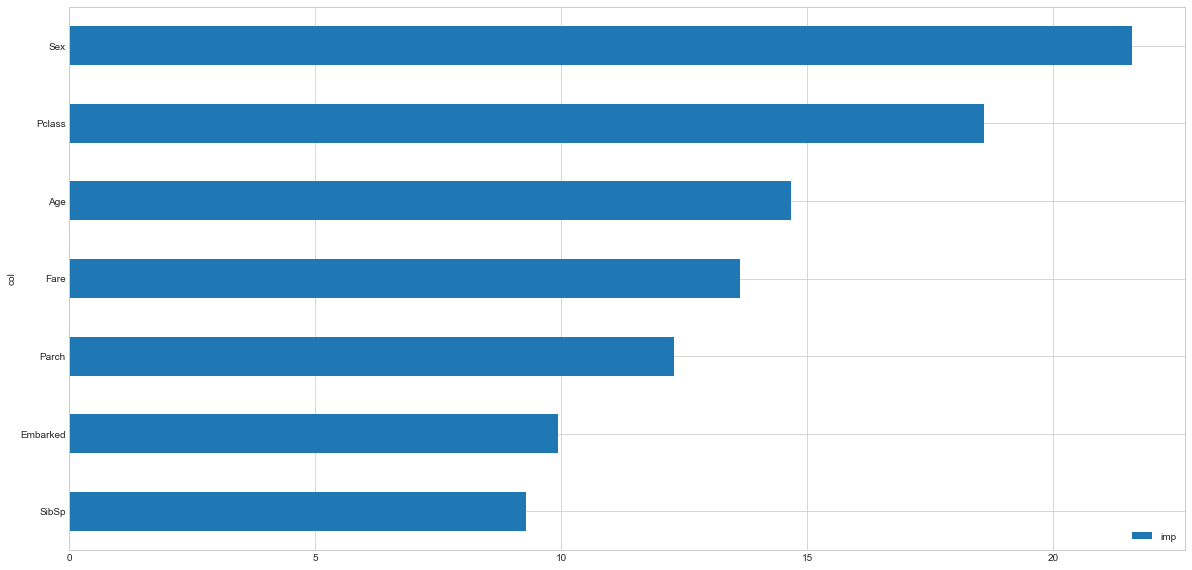

In [113]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score.**

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [114]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8952062999285215
Recall: 0.735614705882353
F1: 0.8068634290824425
AUC: 0.9187733311903996


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Challenge:** What are some ways to visualise precision and recall? 
*Hint:* You may want to look into what a confusion matrix is, you can find much more information in this blog post: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [115]:
# We need our test dataframe to look like this one
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,51,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,47,1,0,189,2
4,2,1,47,0,0,43,2


In [116]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [117]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [118]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [119]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


The columns in `test` have been converted to the same format at `df_con_enc`. Now we can make predictions on the `test` dataframe columns we built a model on.

We can find the columns we made predictions on with `X_train.columns`.

In [120]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [121]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [122]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
      dtype=int64)

In [123]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [124]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [125]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


We need our `submission` dataframe to look like the `gender_submisison` dataframe, so we'll turn the `Survived` column into integers.

In [126]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [127]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [128]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [129]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [130]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## Possible Extensions

These are all possible options to improve this pipeline. I'd suggest starting with the feature engineering (improving and manipulating the existing data) first.

* What can you do with the `Age` feature?
    * How would fill up all the missing values?
    * You may want to look into the `interpolate()` function of Pandas for this
<br>
<br>
2. What can you do with the `Name` feature?
    * What titles did the passengers have? Did this influence their survival?
<br>
<br>
3. What can you do with the `Cabin` feature?
    * Is there a way to see whether they had a cabin or not?
<br>
<br>
4. Can you combine the `SibSp` and `Parch` features to see if the person was alone or not?
<br>
<br>
5. Could you do a PCA/feature analysis to see what features are more important than others?
    * Does removing the less important model features improve the model?
<br>
<br>
7. The models take a bunch of hyperparameters but we've mostly used the default settings, is there a way to find which hyperparameters are best to use?
    * Tip: Check out the `CatBoost` with Python tutorial and the [hyperopt library](https://github.com/hyperopt/hyperopt) to see if you can improve the CatBoost model

## References and Learn More

* [Sklearn Classification Notebook by Daniel Furasso](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb) - Daniel has done some epic work showing how you can take a bigger dataset, clean it up and perform some similar classification work from scratch. It would be a great next step after going through this one.
<br>

* [Encoding categorical features in Python blog post by Practical Python Business](http://pbpython.com/categorical-encoding.html) - this blog post sheds some great light on how to deal with categorical features in Python. The rest of the website contains plenty more great information for using Python in a business environment.
<br>

* [CatBoost Python tutorial on GitHub](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb) - the tutorial is based on the Titanic Dataset and has some great tricks to improve the results in this notebook.
<br>

* [Shap library](https://github.com/slundberg/shap) - a great (and beautiful) alternative to viewing feature importance. Can you use this to improve on the feature importance graphics?